In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Introduction

Learning plays a central role in the construction of pattern classifiers. As we have seen, the general approach is to specify a model having one or more parameters and then estimate their values from training data. When the models are fairly simple and of low dimension, we can use analytic methods such as computing derivatives and performing gradient descent to find optimal model parameters. If the models are somewhat more complicated, we may calculate local derivatives and use gradient methods, as in neural networks and some maximum-likelihood problems. 

In most high-dimensional and complicated models, there are multiple maxima and we must use a variety of tricks — such as performing the search multiple times from different starting conditions — to have any confidence that an acceptable local maximum has been found. These methods become increasingly unsatisfactory as the models become more complex. A naive approach — exhaustive search through solution space — rapidly gets out of hand and is completely impractical for real-world problems. 

The more complicated the model, the less the prior knowledge, and the less the training data, the more we must rely on sophisticated search for finding acceptable model parameters. In this chapter we consider stochastic methods for finding parameters, where randomness plays a crucial role in search and learning. The general approach is to bias the search toward regions where we expect the solution to be and allow randomness — somehow — to help find good parameters, even in very complicated models. 

We shall consider two general classes of such methods. The first, exemplified by Boltzmann learning, is based on concepts and techniques from physics, specifically statistical mechanics. The second, exemplified by genetic algorithms, is based on concepts from biology, specifically the mathematical theory of evolution. The former class has a highly developed and rigorous theory and many successes in pattern recognition; hence it will command most of our effort. The latter class is more heuristic yet affords flexibility and can be attractive when adequate computational resources are available. We shall generally illustrate these techniques in cases that are simple, and which might also be addressed with standard gradient procedures; nevertheless, we emphasize that these stochastic methods may be preferable in complex problems. The methods have high computational burden, and would be of little use without computers.

##  Stochastic Search

We begin by discussing an important and general quadratic optimization problem. Analytic approaches do not scale well to large problems, however, and thus we focus here on methods of search through different candidate solutions. We then consider a form of stochastic search that finds use in learning for pattern recognition. 

Suppose we have a large number of variables $ s_i $, $ i = 1, \dots, N $, where each variable can take one of two discrete values, for simplicity chosen to be $ \pm 1 $. The optimization problem is this: find the values of the $ s_i $ so as to minimize the cost or energy

$$
E = - \frac{1}{2} \sum_{i,j=1}^{N} w_{ij} s_i s_j
$$

where the $ w_{ij} $ can be positive or negative and are problem-dependent. We require the self-feedback terms to vanish, i.e., $ w_{ii} = 0 $, since non-zero $ w_{ii} $ merely add an unimportant constant to $ E $, independent of the $ s_i $. 

This optimization problem can be visualized in terms of a network of nodes, where bi-directional links or interconnections correspond to the weights $ w_{ij} = w_{ji} $. 

The optimization task is to find the configuration of states of the magnets with the most stable configuration, the one with the lowest energy. This general optimization problem appears in a wide range of applications, in many of which the weights do not have a physical interpretation. As mentioned, we shall be particularly interested in its application to learning methods.

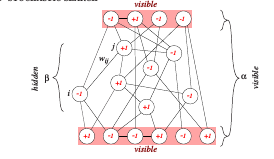

Fig.1: The class of optimization problems of Eq. 1 can be viewed in terms of a network of nodes or units, each of which can be in the si = +1 or si = −1 state. Every pair of nodes i and j is connected by bi-directional weights wij ; if a weight between two nodes is zero then no connection is drawn. (Because the networks we shall discuss can have an arbitrary interconnection, there is no notion of layers as in multilayer neural networks.) The optimization problem is to ﬁnd a conﬁguration (i.e., assignment of all si ) that minimizes the energy described by Eq. 1. The state of the full network is indexed by an integer γ, and since here there are 17 binary nodes, γ is bounded 0 ≤ γ < 217 . The state of the visible nodes and hidden nodes are indexed by α and β, respectively and in this case are bounded 0 ≤ α ≤ 210 and 0 ≤ β < 27 .


## Simulated Annealing

In physics, the method for allowing a system such as many magnets or atoms in an alloy to find a low-energy configuration is based on annealing. In physical annealing, the system is heated, thereby conferring randomness to each component (magnet). As a result, each variable can temporarily assume a value that is energetically unfavorable and the full system explores conﬁgurations that have high energy. 

Annealing proceeds by gradually lowering the temperature of the system — ultimately toward zero and thus no randomness — so as to allow the system to relax into a low-energy configuration. Such annealing is effective because even at moderately high temperatures, the system slightly favors regions in the configuration space that are overall lower in energy, and hence are more likely to contain the global minimum. As the temperature is lowered, the system has increased probability of finding the optimum configuration. 

This method is successful in a wide range of energy functions or energy "landscapes," though there are pathological cases such as the "golf course" landscape in Figure 7.2 where it is unlikely to succeed. Fortunately, the problems in learning we shall consider rarely involve such pathological functions.

##  The Boltzmann Factor

The statistical properties of large numbers of interacting physical components at a temperature $ T $, such as molecules in a gas or magnetic atoms in a solid, have been thoroughly analyzed. A key result, which relies on a few very natural assumptions, is the Boltzmann factor:

$$
P(\gamma) = \frac{e^{-E(\gamma)/T}}{Z(T)}
$$

where $ E(\gamma) $ is the energy of state $ \gamma $, and $ Z(T) $ is the partition function that ensures the probabilities sum to 1.

In the context of pattern recognition and machine learning, we apply these methods to explore the parameter space of models, finding good parameters by allowing some randomness, but also biasing the search towards lower energy states as the temperature decreases.


Final state: [-1  1  1 -1 -1  1  1 -1  1  1]
Final energy: -11.704789715693648


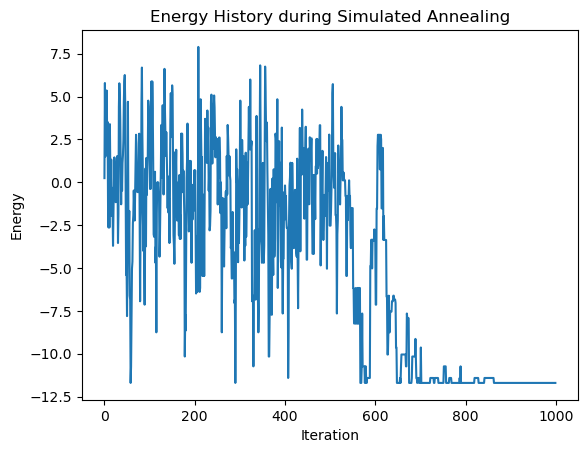

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# Energy function (cost function)
def energy(s, W):
    E = -0.5 * np.sum(np.outer(s, s) * W)  # Matrix form of the energy function
    return E

# Simulated Annealing for Energy Minimization
def simulated_annealing(N, W, max_iter=1000, initial_temp=1000, cooling_rate=0.99):
    # Initialize random state for s (values of +1 or -1)
    s = np.random.choice([-1, 1], size=N)
    
    # Initial energy
    current_energy = energy(s, W)
    
    # Temperature initialization
    temp = initial_temp
    
    # List to store the energy at each iteration for plotting
    energy_history = []
    
    # Simulated Annealing loop
    for iteration in range(max_iter):
        # Pick a random variable to flip
        i = random.randint(0, N-1)
        s_new = s.copy()
        s_new[i] = -s_new[i]  # Flip the selected variable
        
        # Calculate new energy
        new_energy = energy(s_new, W)
        
        # Accept new configuration with probability based on energy difference and temperature
        delta_E = new_energy - current_energy
        if delta_E < 0 or random.random() < math.exp(-delta_E / temp):
            s = s_new
            current_energy = new_energy
        
        # Cool down the temperature
        temp *= cooling_rate
        
        # Record the energy for plotting
        energy_history.append(current_energy)
    
    return s, current_energy, energy_history

# Example of usage:

# Set up parameters
N = 10  # Number of variables
np.random.seed(0)  # For reproducibility

# Randomly initialize the weight matrix W (symmetric, no self-feedback)
W = np.random.randn(N, N)
W = (W + W.T) / 2  # Make the matrix symmetric
np.fill_diagonal(W, 0)  # Set self-feedback to zero

# Run simulated annealing
final_state, final_energy, energy_history = simulated_annealing(N, W)

# Output the results
print(f"Final state: {final_state}")
print(f"Final energy: {final_energy}")

# Plot the energy history
plt.plot(energy_history)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy History during Simulated Annealing')
plt.show()


Final state: [1, -1, -1, -1, 1, 1, 1, 1, -1, 1]
Final energy: -17.760018456609963


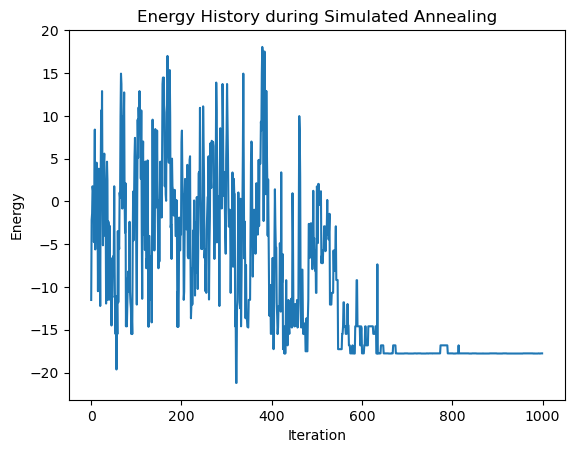

In [2]:
import random
import math
import matplotlib.pyplot as plt

# Energy function (cost function) - without numpy
def energy(s, W):
    E = 0
    N = len(s)
    for i in range(N):
        for j in range(N):
            E -= 0.5 * W[i][j] * s[i] * s[j]
    return E

# Simulated Annealing for Energy Minimization - without numpy
def simulated_annealing(N, W, max_iter=1000, initial_temp=1000, cooling_rate=0.99):
    # Initialize random state for s (values of +1 or -1)
    s = [random.choice([-1, 1]) for _ in range(N)]
    
    # Initial energy
    current_energy = energy(s, W)
    
    # Temperature initialization
    temp = initial_temp
    
    # List to store the energy at each iteration for plotting
    energy_history = []
    
    # Simulated Annealing loop
    for iteration in range(max_iter):
        # Pick a random variable to flip
        i = random.randint(0, N-1)
        s_new = s.copy()
        s_new[i] = -s_new[i]  # Flip the selected variable
        
        # Calculate new energy
        new_energy = energy(s_new, W)
        
        # Accept new configuration with probability based on energy difference and temperature
        delta_E = new_energy - current_energy
        if delta_E < 0 or random.random() < math.exp(-delta_E / temp):
            s = s_new
            current_energy = new_energy
        
        # Cool down the temperature
        temp *= cooling_rate
        
        # Record the energy for plotting
        energy_history.append(current_energy)
    
    return s, current_energy, energy_history

# Example of usage:

# Set up parameters
N = 10  # Number of variables
random.seed(0)  # For reproducibility

# Randomly initialize the weight matrix W (symmetric, no self-feedback)
W = [[random.gauss(0, 1) for _ in range(N)] for _ in range(N)]
# Make the matrix symmetric
for i in range(N):
    for j in range(i + 1, N):
        W[j][i] = W[i][j]
# Set self-feedback to zero
for i in range(N):
    W[i][i] = 0

# Run simulated annealing
final_state, final_energy, energy_history = simulated_annealing(N, W)

# Output the results
print(f"Final state: {final_state}")
print(f"Final energy: {final_energy}")

# Plot the energy history
plt.plot(energy_history)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy History during Simulated Annealing')
plt.show()


##  Simulated Annealing

In physics, the method for allowing a system such as many magnets or atoms in an alloy to find a low-energy configuration is based on annealing. In physical annealing, the system is heated, thereby conferring randomness to each component (magnet). As a result, each variable can temporarily assume a value that is energetically unfavorable, and the full system explores configurations that have high energy. 

Annealing proceeds by gradually lowering the temperature of the system — ultimately toward zero and thus no randomness — so as to allow the system to relax into a low-energy configuration. Such annealing is effective because, even at moderately high temperatures, the system slightly favors regions in the configuration space that are overall lower in energy, and hence are more likely to contain the global minimum. As the temperature is lowered, the system has an increased probability of finding the optimum configuration.

This method is successful in a wide range of energy functions or energy “landscapes,” though there are pathological cases such as the “golf course” landscape where it is unlikely to succeed. Fortunately, the problems in learning we shall consider rarely involve such pathological functions.

###  The Boltzmann Factor

The statistical properties of large numbers of interacting physical components at a temperature $T$, such as molecules in a gas or magnetic atoms in a solid, have been thoroughly analyzed. A key result, which relies on a few very natural assumptions, is the Boltzmann factor:

$$
P(\gamma) = \frac{e^{-E(\gamma)/T}}{Z(T)}
$$

where $E(\gamma)$ is the energy of state $\gamma$, and $Z(T)$ is the partition function that ensures the probabilities sum to 1:

$$
Z(T) = \sum_{\gamma} e^{-E(\gamma)/T}
$$

The number of configurations is very high, $2^N$, and in physical systems, \(Z\) can be calculated only in simple cases. Fortunately, we need not calculate the partition function in the context of simulated annealing, as we shall see.

Because of the fundamental importance of the Boltzmann factor, it pays to take a slight detour to understand it informally. Consider a different, but nonetheless related system: one consisting of a large number of non-interacting magnets, that is, without interconnecting weights, in a uniform external magnetic field. If a magnet is pointing up, $s_i = +1$ (in the same direction as the field), it contributes a small positive energy to the total system; if the magnet is pointing down, it contributes a small negative energy.

The total energy of the collection is thus proportional to the total number of magnets pointing up. The probability that the system has a particular total energy is related to the number of configurations that have that energy. For example:

- The highest energy configuration, with all magnets pointing up, has only 1 configuration.
- The next highest energy has just one magnet pointing down, and there are $N_1 = N$ such configurations.
- The next lower energy configurations have two magnets pointing down, and there are $N_2 = \frac{N(N-1)}{2}$ of these, and so on.

The number of states declines exponentially with increasing energy. Because of the statistical independence of the magnets, for large $N$, the probability of finding the state in energy $E$ also decays exponentially. In sum, then, the exponential form of the Boltzmann factor is due to the exponential decrease in the number of accessible configurations with increasing energy. 

Further, at high temperature, there is roughly more energy available and thus an increased probability of higher-energy states. This describes qualitatively the dependence of the probability on $T$ in the Boltzmann factor — at high $T$, the probability is distributed roughly evenly among all configurations, while at low $T$, it is concentrated at the lowest-energy configurations.

### Simulated Annealing Algorithm

The above discussion and the physical analogy suggest the following simulated annealing method for finding the optimum configuration to our general optimization problem:

1. Start with randomized states throughout the network $s_i^{(1)}$, and select a high initial "temperature" $T^{(1)}$.
2. Next, choose a node $i$ randomly. Suppose its state is $s_i = +1$.
3. Calculate the system energy in this configuration, $E_a$; next recalculate the energy, $E_b$, for a candidate new state $s_i = -1$.
4. If the candidate state has a lower energy, accept this change in state. If the energy is higher, accept this change with a probability equal to:

$$
P_{\text{accept}} = e^{-\Delta E_{ab}/T}
$$

where $\Delta E_{ab} = E_b - E_a$.

This occasional acceptance of a state that is energetically less favorable is crucial to the success of simulated annealing and is in marked distinction to naive gradient descent. The key benefit is that it allows the system to jump out of unacceptable local energy minima.

At very high temperatures, every configuration has a Boltzmann factor $e^{-E/T} \approx e^0 $, which is roughly equal. After normalization, every configuration is roughly equally likely. This implies every node is equally likely to be in either of its two states.

The algorithm continues by polling (selecting and testing) the nodes randomly several times and setting their states. Then the temperature is lowered and the polling is repeated. As the temperature lowers, the probability of accepting higher energy states diminishes, and the search becomes more greedy.

Simulated annealing terminates when the temperature is very low (near zero). If this cooling process is sufficiently slow, the system has a high probability of being in a low-energy state, ideally the global energy minimum.


In [3]:
import random
import math

def energy(s, w):
    """
    Calculate the energy of the configuration.
    s: List of states for each node (e.g., +1, -1)
    w: Weight matrix representing the connections between nodes
    """
    N = len(s)
    E = 0
    for i in range(N):
        for j in range(N):
            if i != j:
                E -= w[i][j] * s[i] * s[j]
    return E

def simulated_annealing(w, initial_temperature=1000, final_temperature=1e-3, cooling_rate=0.995, max_iter=1000):
    """
    Perform simulated annealing to find a low-energy configuration.

    w: Weight matrix (NxN)
    initial_temperature: Starting temperature
    final_temperature: Temperature at which the algorithm will stop
    cooling_rate: Rate at which the temperature cools down
    max_iter: Maximum number of iterations before stopping
    """
    # Initialize random configuration of states (+1 or -1)
    N = len(w)
    s = [random.choice([-1, 1]) for _ in range(N)]

    # Initial energy of the configuration
    E = energy(s, w)
    
    # Start with the initial temperature
    temperature = initial_temperature
    
    # Main loop
    iteration = 0
    while temperature > final_temperature and iteration < max_iter:
        # Choose a random node
        i = random.randint(0, N - 1)
        
        # Save the current energy
        current_energy = E
        
        # Flip the state of the selected node
        s[i] = -s[i]
        
        # Calculate the new energy after flipping
        new_energy = energy(s, w)
        
        # If the new energy is lower, accept the move
        if new_energy < current_energy:
            E = new_energy
        else:
            # Accept the move with a certain probability
            delta_E = new_energy - current_energy
            probability = math.exp(-delta_E / temperature)
            if random.random() < probability:
                E = new_energy
            else:
                # Revert the flip if it's not accepted
                s[i] = -s[i]
        
        # Cool the temperature
        temperature *= cooling_rate
        iteration += 1
    
    return s, E

# Example: Testing the Simulated Annealing
# Define a simple weight matrix (example)
# This represents a fully connected system with random weights between nodes
N = 5
w = [[random.uniform(-1, 1) if i != j else 0 for j in range(N)] for i in range(N)]

# Perform simulated annealing
solution, final_energy = simulated_annealing(w)

print("Final configuration: ", solution)
print("Final energy: ", final_energy)


Final configuration:  [1, 1, -1, -1, 1]
Final energy:  3.516970761018036


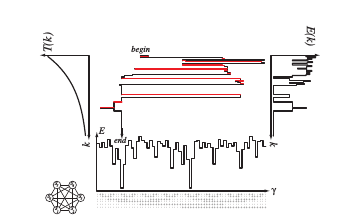

Fig.3: Stochastic simulated annealing (Algorithm 1) uses randomness, governed by a control parameter or “temperature” T (k) to search through a discrete space for a minimum of an energy function. In this example there are N = 6 variables; the 26 = 64 conﬁgurations are shown at the bottom along as a column of + and -. The plot of the associated energy of each conﬁguration given by Eq. 1 for randomly chosen weights. Every transition corresponds to the change of just a single si . (The conﬁgurations have been arranged so that adjacent ones diﬀer by the state of just a single node; nevertheless most transitions corresponding to a single node appear far apart in this ordering.) Because the system energy is invariant with respect to a global interchange si ↔ −si , there are two “global” minima. The graph at the upper left shows the annealing schedule — the decreasing temperature versus iteration number k. The middle portion shows the conﬁguration versus iteration number generated by Algorithm 1. The trajectory through the conﬁguration space is colored red for transitions that increase the energy; late in the annealing such energetically unfavorable (red) transitions are rarer. The graph at the right shows the full energy E(k), which decreases to the global minimum.

## Stochastic Simulated Annealing

Simulated annealing is a probabilistic technique used for finding an approximate solution to an optimization problem, particularly useful when the search space is discrete and large. The algorithm explores the search space by gradually reducing the randomness or "temperature."

## Algorithm Overview

In the stochastic simulated annealing, nodes (variables) are updated sequentially, where each node is evaluated individually. The basic idea is to poll a node, calculate the energy change if its state is flipped, and then decide whether to accept this new state based on the energy difference and the current temperature.

### Algorithm Steps

1. **Initialization**:
    - Initialize the temperature $ T(k) $, the maximum number of iterations $ k_{\text{max}} $, and the states $ s_i(1) $ of all the nodes.
    - Initialize the weights $ w_{ij} $ for each node pair $ (i, j) $.
  
2. **Iterations**:
    - At each iteration, the following steps are performed:
    
    **For each node $ i $**:
    - Select node $ i $ randomly.
    - Calculate the energy $ E_a $ of the current state of node $ i $:
    $$
    E_a = -\frac{1}{2} \sum_{j \in N_i} w_{ij} s_i s_j
    $$
    where $ N_i $ is the set of nodes connected to node $ i $, and $ s_i $ is the state of node $ i $.

    - Flip the state of node $ i $ (i.e., set $ s_i $ to $ -s_i $) and calculate the new energy $ E_b $:
    $$
    E_b = -E_a
    $$
    
    - If \( E_b < E_a \), then accept the new state by setting $ s_i = -s_i $.
    - Otherwise, accept the new state with a probability:
    $$
    P = \exp\left(-\frac{E_b - E_a}{T(k)}\right)
    $$
    if $ \text{Rand}[0,1) < P $, where $ \text{Rand}[0, 1) $ is a randomly selected real number between 0 and 1.

3. **Temperature Update**:
    - After all nodes are polled once, decrease the temperature according to the annealing schedule:
    $$
    T(k + 1) = c \cdot T(k)
    $$
    where $ 0 < c < 1 $ is a constant cooling rate.

4. **Stopping Criteria**:
    - The algorithm stops when either the temperature $ T(k) $ is sufficiently low (i.e., close to zero) or the maximum number of iterations $ k_{\text{max}} $ is reached.

5. **Return**:
    - The algorithm returns the final energy and the states $ s_i $ of all nodes, ideally corresponding to a low-energy state (global minimum).

## Annealing Schedule

The temperature $ T(k) $ is gradually reduced over the course of the algorithm. A typical annealing schedule is:
$$
T(k+1) = c T(k), \quad 0 < c < 1
$$
The initial temperature $ T(1) $ is set high enough to allow all configurations to be explored with roughly equal probability. As the temperature decreases, the system becomes less random, and it increasingly favors configurations with lower energy.

### Parameters
- **Initial Temperature $ T(1) $**: Should be sufficiently high to explore all possible states.
- **Cooling Rate $ c $**: A value in the range $ 0.8 < c < 0.99 $ is typically effective.
- **Stopping Criterion**: The algorithm either stops when the temperature is low enough or after a pre-defined number of iterations.

## Energy Function

The energy function is defined as:
$$
E = -\frac{1}{2} \sum_{i,j \in N} w_{ij} s_i s_j
$$
where $ w_{ij} $ represents the weight between node $ i $ and node $ j $, and $ s_i $ and $ s_j $ are the states of these nodes.

## Example

Consider a small system with $ N = 6 $ nodes and random weights. The states are initially random, and the energy function is computed for each configuration. The algorithm will attempt to find the state configuration with the minimum energy, which corresponds to the global minimum of the system.

### Cooling Schedule Visualization
The cooling schedule is plotted as a function of the iteration number, showing how the temperature decreases as the algorithm progresses. Early in the annealing process, when the temperature is high, the system explores a wide range of configurations. As the temperature lowers, the system concentrates its search around lower energy configurations.

### Energy vs. Iteration
The energy of the system decreases over time as the algorithm converges to a minimum. Early in the process, the energy may fluctuate, but as the temperature approaches its final value, the system's energy stabilizes at a global minimum.

## Deterministic Simulated Annealing

An alternative to stochastic simulated annealing is deterministic simulated annealing. In this version, nodes take continuous values, and the temperature affects the degree of certainty in their state. The update rule is modified as follows:

$$
s_i = \tanh\left(\frac{l_i}{T}\right)
$$
where $ l_i = \sum_{j} w_{ij} s_j $ represents the force exerted on node $ i $, and $ T $ is the current temperature.

At high temperatures, nodes take on values between -1 and 1, while at low temperatures, they are forced to take extreme values of either -1 or 1, similar to the discrete case.

## Conclusion

Simulated annealing provides an effective way to explore large, complex search spaces. By allowing for occasional moves to higher energy configurations, the algorithm avoids getting trapped in local minima and can find the global minimum in many cases.



Final States: [-1 -1 -1 -1 -1  1 -1  1  1  1]
Final Energy: -1.4301719347708062


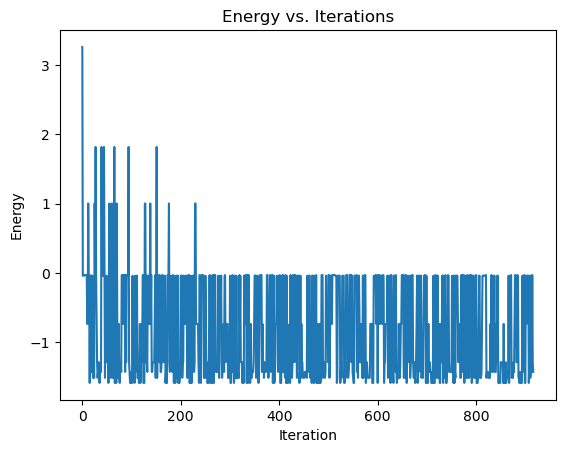

In [4]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# Define the energy function
def compute_energy(states, weights, N):
    energy = 0
    for i in range(N):
        for j in range(N):
            if i != j:
                energy -= 0.5 * weights[i, j] * states[i] * states[j]
    return energy

# Stochastic Simulated Annealing Algorithm
def stochastic_annealing(weights, N, T_initial, T_final, k_max, c):
    # Initialize the system
    states = np.random.choice([-1, 1], size=N)  # Random initial states
    energy = compute_energy(states, weights, N)  # Initial energy
    T = T_initial  # Initial temperature
    energy_history = []  # To track energy history during annealing
    
    for k in range(k_max):
        energy_history.append(energy)
        
        # Randomly select a node
        i = random.randint(0, N-1)
        
        # Calculate the energy of the current state
        Ea = -0.5 * np.sum(weights[i] * states * states)  # Energy for current state
        Eb = -Ea  # Energy for flipped state
        
        # Metropolis criterion (probability to accept the new state)
        if Eb < Ea:
            states[i] = -states[i]
            energy = Eb
        else:
            # Accept with a probability based on the temperature
            prob = math.exp(-(Eb - Ea) / T)
            if random.random() < prob:
                states[i] = -states[i]
                energy = Eb
        
        # Update temperature according to the cooling schedule
        T = c * T
        if T < T_final:
            break  # Stop if temperature is below the final threshold
    
    return states, energy, energy_history

# Parameters for the optimization problem
N = 10  # Number of nodes
weights = np.random.randn(N, N)  # Random weights matrix (symmetric)
weights = (weights + weights.T) / 2  # Make the weight matrix symmetric

T_initial = 10  # Initial temperature
T_final = 0.001  # Final temperature
k_max = 10000  # Maximum number of iterations
c = 0.99  # Cooling rate

# Run the stochastic annealing
final_states, final_energy, energy_history = stochastic_annealing(weights, N, T_initial, T_final, k_max, c)

# Output the results
print("Final States:", final_states)
print("Final Energy:", final_energy)

# Plot the energy history
plt.plot(energy_history)
plt.title("Energy vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()


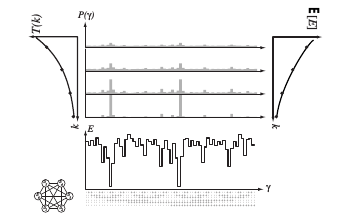

Fig.4: An estimate of the probability P (γ) of being in a conﬁguration denoted by γ is shown for four temperatures during a slow anneal. (These estimates, based on a large number of runs, are nearly the theoretical values e−Eγ /T ) Early, at high T , each conﬁguration is roughly equal in probability while late, at low T , the probability is strongly concentrated at the global minima. The expected value of the energy, E[E] (i.e., averaged at temperature T ), decreases gradually during the anneal.

## Deterministic Simulated Annealing

In **deterministic simulated annealing**, each node can take on a continuous value between $ -1 \leq s_i \leq +1 $, which represents the expected value of a binary node in the system at a given temperature $ T $. The analog value $ s_i $ replaces the expectation of the discrete variable $ E[s_i] $. We define $ l_i $ as the force exerted by the nodes connected to $ s_i $, and it is given by the equation:

$$ l_i = \sum_j w_{ij} s_j $$

where $ w_{ij} $ represents the weight of the connection between nodes $ i $ and $ j $.

The update function for the node state $ s_i $ is given by:

$$ s_i = f(l_i, T) = \tanh\left(\frac{l_i}{T}\right) $$

### The Algorithm for Deterministic Simulated Annealing:

1. **Initialize** the temperature schedule $ T(k) $, weights $ w_{ij} $, and the initial states $ s_i^{(1)} $ for all nodes.
2. Set $ k = 0 $.
3. Repeat until convergence or a stopping criterion is met:
    - Increase $ k $ by 1.
    - **Select node** $ i $ randomly from the set of nodes connected to $ i $, denoted $ N_i $.
    - **Compute the force** $ l_i = \sum_j w_{ij} s_j $.
    - **Update the node state**: $ s_i = f(l_i, T(k)) $, where $ f $ is the transfer function.
4. **Return** the final states $ s_i $ and the energy $ E $.

$$ E = -\frac{1}{2} \sum_{i,j} w_{ij} s_i s_j $$

### Visualization of Deterministic Annealing:

Fig.5 illustrates how the value of $ s_i $ evolves based on the forces $ l_i $ exerted by neighboring nodes. At **high temperatures** (large $ T $), the node state $ s_i $ is highly random, whereas at **low temperatures** (small $ T $), even a small positive force will push $ s_i $ towards +1, and similarly, a large negative force will push it towards -1.

- For high $ T $, the node may stay at intermediate values, as the randomness dominates.
- As $ T $ decreases, $ s_i $ becomes more deterministic, moving closer to +1 or -1, which is the final state for each node at low temperatures.

### Efficiency of Deterministic Annealing

In practice, **deterministic annealing** is faster than **stochastic annealing**, especially for large problems. The main difference is that deterministic annealing updates all nodes simultaneously (or deterministically), while stochastic annealing updates one node at a time. As a result, deterministic annealing can give similar solutions more quickly, sometimes by several orders of magnitude.

---

### Application: Boltzmann Learning for Pattern Recognition

In **Boltzmann learning**, we apply the principles of simulated annealing to pattern recognition. Consider a network where:

- The **input units** represent binary features of an input pattern.
- The **output units** represent the categories, typically in a 1-of-c encoding.

During classification, the input units are **clamped** to the feature values of the input pattern, and the remaining units are annealed to find the configuration with the lowest energy, which corresponds to the most probable configuration for the given input.

The weights $ w_{ij} $ of the network are updated through the learning process, and the category information is read from the final values of the output units.

---

### Probability Distribution During Annealing

As we anneal the system, the probability $ P(\gamma) $ of being in a configuration $ \gamma $ changes with temperature. At **high temperatures**, all configurations have roughly equal probability, but at **low temperatures**, the probability becomes concentrated around the **global minima**.

The expected energy $ E[E] $, averaged over the configurations at each temperature, decreases gradually as the temperature is lowered.

The transition from random to deterministic behavior during the annealing process is shown in Figure 7.4, where at low temperatures, the system is highly likely to be in the optimal configuration, the global minima.



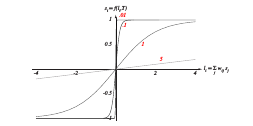

Fig.5: In deterministic annealing, each node can take on a continuous value −1 ≤ si ≤ +1, which equals the expected value of a binary node in the system at temperature T . In other words, the analog value si replaces the expectation of the discrete variable, E[si ]. We let li denote a force exerted by the nodes connected to si . The larger this force, the closer the analog si is to +1; the more negative this force, the closer to −1. The temperature T (marked in red) also aﬀects si . If T is large, there is a great deal of randomness and even a large force will not insure si ≈ +1. At low temperature, there is little or no randomness and even a small positive force insures that si = +1. Thus at the end of an anneal, each node has value si = +1 or si = −1.

In [5]:
import numpy as np

# Activation function for deterministic annealing
def f(l_i, T):
    """The activation function for deterministic annealing."""
    return np.tanh(l_i / T)

# Deterministic Simulated Annealing
def deterministic_simulated_annealing(N, weights, initial_states, T_schedule, max_iter=1000):
    """
    Performs deterministic simulated annealing.

    Parameters:
    N (int): Number of nodes.
    weights (np.ndarray): The weight matrix (NxN).
    initial_states (np.ndarray): Initial states of the nodes.
    T_schedule (function): Function to update temperature, takes the iteration number as input.
    max_iter (int): Maximum number of iterations.

    Returns:
    np.ndarray: Final states of the nodes after annealing.
    """
    # Initialize the states and temperature
    s = initial_states.copy()
    for k in range(1, max_iter + 1):
        # Update the temperature based on the schedule
        T = T_schedule(k)

        # Randomly select a node i
        i = np.random.randint(0, N)

        # Compute the force l_i exerted by connected nodes
        l_i = np.sum(weights[i] * s)

        # Update the state of node i using the activation function f
        s[i] = f(l_i, T)

    return s

# Example usage

# Number of nodes
N = 10

# Random weights for connections between nodes (symmetric matrix)
weights = np.random.randn(N, N)
weights = (weights + weights.T) / 2  # Make the weight matrix symmetric

# Initial states for each node (-1 or 1)
initial_states = np.random.choice([-1, 1], size=N)

# Temperature schedule: starting high, decreasing over time
def T_schedule(k):
    return 1.0 / np.log(k + 1)
    
# Run deterministic simulated annealing
final_states = deterministic_simulated_annealing(N, weights, initial_states, T_schedule, max_iter=1000)

print("Final states:", final_states)


Final states: [0 0 0 0 0 0 0 0 0 0]


Final states: [0.9999999999999999, 1.0, -0.9999999999999886, 0.9347237369931081, -0.9999999945411069, 0.9999999998938497, 1.0, 0.9999988179530064, 0.9984490961667785, -1.0]


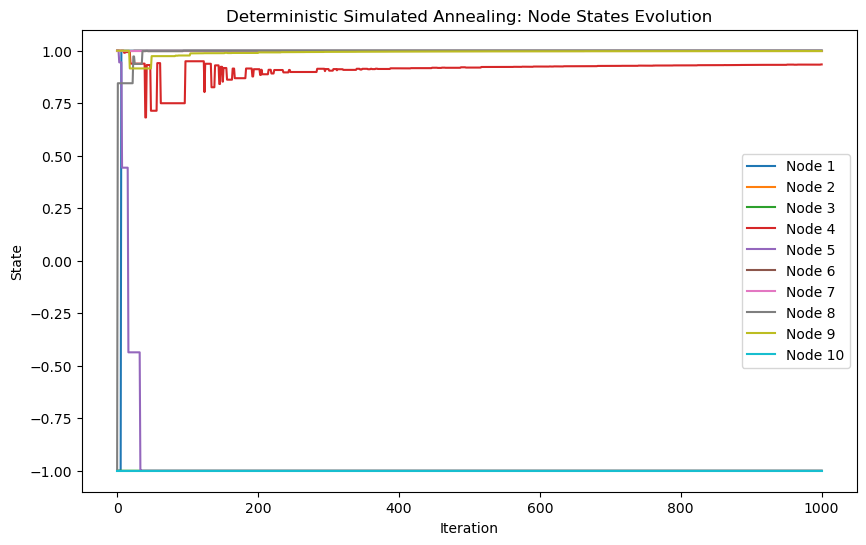

In [6]:
import random
import math
import matplotlib.pyplot as plt

# Activation function for deterministic annealing
def f(l_i, T):
    """The activation function for deterministic annealing."""
    return math.tanh(l_i / T)

# Deterministic Simulated Annealing
def deterministic_simulated_annealing(N, weights, initial_states, T_schedule, max_iter=1000):
    """
    Performs deterministic simulated annealing.

    Parameters:
    N (int): Number of nodes.
    weights (list of list): The weight matrix (NxN).
    initial_states (list): Initial states of the nodes.
    T_schedule (function): Function to update temperature, takes the iteration number as input.
    max_iter (int): Maximum number of iterations.

    Returns:
    list: Final states of the nodes after annealing.
    """
    # Initialize the states and temperature
    s = initial_states[:]
    state_history = [s[:]]  # To store the history of states for plotting

    for k in range(1, max_iter + 1):
        # Update the temperature based on the schedule
        T = T_schedule(k)

        # Randomly select a node i
        i = random.randint(0, N - 1)

        # Compute the force l_i exerted by connected nodes
        l_i = sum(weights[i][j] * s[j] for j in range(N))

        # Update the state of node i using the activation function f
        s[i] = f(l_i, T)

        # Store the state history for plotting
        state_history.append(s[:])

    return s, state_history

# Example usage

# Number of nodes
N = 10

# Random weights for connections between nodes (symmetric matrix)
weights = [[random.gauss(0, 1) for _ in range(N)] for _ in range(N)]
# Make the weight matrix symmetric
for i in range(N):
    for j in range(i + 1, N):
        weights[j][i] = weights[i][j]

# Initial states for each node (-1 or 1)
initial_states = [random.choice([-1, 1]) for _ in range(N)]

# Temperature schedule: starting high, decreasing over time
def T_schedule(k):
    return 1.0 / math.log(k + 1)

# Run deterministic simulated annealing
final_states, state_history = deterministic_simulated_annealing(N, weights, initial_states, T_schedule, max_iter=1000)

# Print the final states
print("Final states:", final_states)

# Plotting the evolution of the system
plt.figure(figsize=(10, 6))

# Create a plot for each node's state over time
for i in range(N):
    plt.plot([state[i] for state in state_history], label=f"Node {i + 1}")

plt.xlabel('Iteration')
plt.ylabel('State')
plt.title('Deterministic Simulated Annealing: Node States Evolution')
plt.legend()
plt.show()




## Boltzmann Learning

## Overview
For pattern recognition, we use a network like the one in Fig. 7.1, where:
- **Input units** accept binary feature information.
- **Output units** represent categories in a 1-of- representation (Fig.7).

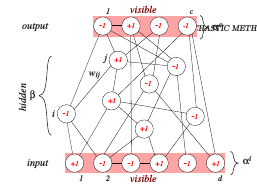

Fig.7: When a network such as shown in Fig.1 is used for learning, it is important to distinguish between two types of visible units — the d input units and c output units, which receive external feature and category information — as well as the remaining, hidden units. The state of the full network is indexed by an integer γ, and since here there are 17 binary nodes, γ is bounded 0 ≤ γ < 217 . The state of the visible nodes is described by α; moreover, αi describes the input and αo the output (the superscripts are not indexes, but merely refer to the input and output, respectively). The state of the hidden nodes is indexed by β.

During classification, the input units are clamped to the feature values of the input pattern, while the remaining units are annealed to find the lowest energy, most probable configuration. The category information is then read from the output units' final values. For accurate recognition, the network requires properly trained weights.

## Energy Landscape
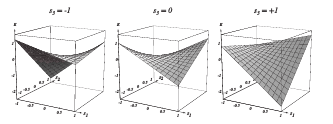

Fig.6: If the state variables si can assume analog values (as in mean-ﬁeld anneal- ing), the energy in Eq. 1 is a general quadratic form having minima at the extreme val- ues si = ±1. In this case N = 3 nodes are fully interconnected with arbitrary weights wij . While the total energy function is three-dimensional, we show two-dimensional surfaces for each of three values of s3 . The energy is linear in each variable so long as the other variables are held ﬁxed. Further, the energy is invariant with respect to the interchange of all variables si ↔ −si . In particular, here the global minimum occurs as s1 = −1, s2 = +1 and s3 = −1 as well as the symmetric conﬁguration s1 = +1, s2 = −1 and s3 = +1.

If the state variables $s_i$ can take analog values (as in mean-field annealing), the energy in the configuration is a general quadratic form, with minima at the extreme values $s_i = \pm 1$ (Fig. 7.6). The energy function for a fully interconnected network with $N=3$ nodes is depicted, showing two-dimensional surfaces for various values of $s_3$.

The total energy function is:
$$
E = \sum_{i < j} w_{ij} s_i s_j
$$

where $w_{ij}$ are the weights and $s_i$ are the states of the nodes.

## Learning Weights
To learn proper weights from training patterns, we use Boltzmann learning. Two approaches exist:
1. **Stochastic simulated annealing.**
2. **Deterministic simulated annealing.**

### Stochastic Boltzmann Learning of Visible States
The learning problem involves matching the desired probabilities $Q(\alpha)$ (from the training set) with the actual probabilities $P(\alpha)$ (from simulations). Here:
- $\alpha$ represents visible configurations (input and output units).
- $\beta$ represents hidden configurations.

The probability of a visible configuration $\alpha$ is:
$$
P(\alpha) = \sum_{\beta} P(\alpha, \beta) = \frac{1}{Z} \sum_{\beta} e^{-E_{\alpha\beta} / T}
$$
where $Z$ is the partition function:
$$
Z = \sum_{\alpha, \beta} e^{-E_{\alpha\beta} / T}
$$

### Kullback-Leibler Divergence
To measure the difference between the desired and actual probabilities, we use the relative entropy:
$$
D_{KL}(Q(\alpha), P(\alpha)) = \sum_{\alpha} Q(\alpha) \log \frac{Q(\alpha)}{P(\alpha)}
$$
This value is minimized using gradient descent.

### Gradient Descent for Learning
The weights are updated as:
$$
\Delta w_{ij} = -\eta \frac{\partial D_{KL}}{\partial w_{ij}} = \eta \sum_{\alpha} \frac{Q(\alpha)}{P(\alpha)} \frac{\partial P(\alpha)}{\partial w_{ij}}
$$

Substituting the derivative of $P(\alpha)$:
$$
\frac{\partial P(\alpha)}{\partial w_{ij}} = \frac{1}{T} \left[ \sum_{\beta} s_i(\alpha\beta) s_j(\alpha\beta) P(\alpha, \beta) - P(\alpha) E[s_i s_j] \right]
$$

### Weight Update Rule
Combining terms, we get:
$$
\Delta w_{ij} = \frac{\eta}{T} \left[ E_Q[s_i s_j]_{\text{clamped}} - E[s_i s_j]_{\text{free}} \right]
$$
where:
- $E_Q[s_i s_j]_{\text{clamped}}$: Correlation of $s_i$ and $s_j$ when visible units are clamped to the training pattern.
- $E[s_i s_j]_{\text{free}}$: Correlation of $s_i$ and $s_j$ when units are free to vary.

The first term (learning component) reinforces patterns from the training data. The second term (unlearning component) removes spurious correlations.

### Algorithm Summary
1. Present each training pattern multiple times.
2. Clamp visible units to the pattern values.
3. Compute $E_Q[s_i s_j]_{\text{clamped}}$ and $E[s_i s_j]_{\text{free}}$.
4. Update weights using the rule:
   $$
   \Delta w_{ij} = \frac{\eta}{T} \left[ E_Q[s_i s_j]_{\text{clamped}} - E[s_i s_j]_{\text{free}} \right]
   $$




In [8]:
### Boltzmann Learning Algorithm in Python

#```python
import random
import math

# Define the energy function
def energy(states, weights):
    """
    Calculate the energy of the system given states and weights.

    Parameters:
    states (list): States of the nodes.
    weights (list of list): Weight matrix.

    Returns:
    float: Energy of the configuration.
    """
    N = len(states)
    E = 0
    for i in range(N):
        for j in range(i + 1, N):
            E += weights[i][j] * states[i] * states[j]
    return -E

# Generate initial states for nodes
def initialize_states(N):
    """Randomly initialize the states of N nodes."""
    return [random.choice([-1, 1]) for _ in range(N)]

# Compute the probability of a state
def state_probability(states, weights, T):
    """Compute the probability of a given state based on its energy."""
    E = energy(states, weights)
    return math.exp(-E / T)

# Update weights based on Boltzmann learning rule
def update_weights(weights, visible_states, hidden_states, learning_rate, T):
    """Update the weights according to the Boltzmann learning rule."""
    N = len(weights)
    delta_weights = [[0 for _ in range(N)] for _ in range(N)]

    # Compute correlations in clamped and free states
    for i in range(N):
        for j in range(i + 1, N):
            # Clamped correlations
            clamped_corr = visible_states[i] * visible_states[j]
            # Free correlations
            free_corr = hidden_states[i] * hidden_states[j]

            # Update weight
            delta_weights[i][j] = (clamped_corr - free_corr) / T
            delta_weights[j][i] = delta_weights[i][j]

    # Apply updates to the weights
    for i in range(N):
        for j in range(N):
            weights[i][j] += learning_rate * delta_weights[i][j]

# Training Boltzmann Machine
def train_boltzmann_machine(weights, training_data, learning_rate, T, epochs):
    """
    Train a Boltzmann machine using training data.

    Parameters:
    weights (list of list): Initial weight matrix.
    training_data (list of list): Training patterns.
    learning_rate (float): Learning rate for weight updates.
    T (float): Temperature.
    epochs (int): Number of training epochs.

    Returns:
    list of list: Updated weight matrix.
    """
    N = len(weights)
    for epoch in range(epochs):
        for pattern in training_data:
            # Visible and hidden states
            visible_states = pattern
            hidden_states = initialize_states(N)

            # Update weights based on learning rule
            update_weights(weights, visible_states, hidden_states, learning_rate, T)
    return weights

# Example usage
if __name__ == "__main__":
    # Number of nodes
    N = 5

    # Initialize weight matrix randomly
    weights = [[random.uniform(-0.1, 0.1) for _ in range(N)] for _ in range(N)]
    for i in range(N):
        weights[i][i] = 0  # No self-loops

    # Training data (binary input patterns)
    training_data = [
        [1, -1, 1, -1, 1],
        [-1, 1, -1, 1, -1],
        [1, 1, -1, -1, 1]
    ]

    # Hyperparameters
    learning_rate = 0.01
    T = 1.0  # Temperature
    epochs = 100

    # Train the Boltzmann machine
    updated_weights = train_boltzmann_machine(weights, training_data, learning_rate, T, epochs)

    print("Updated Weights:")
    for row in updated_weights:
        print(row)


Updated Weights:
[0.0, -1.1398836814193258, 0.851025415945229, -3.0105016329999748, 2.986143605398358]
[-1.1348809002774034, 0.0, -2.8530909505230313, 0.8476764553743661, -0.939652331773863]
[0.78533778624067, -2.8982174564656504, 0.0, -0.903097336357815, 1.0996189305082151]
[-3.041868478993125, 0.7657121081987509, -0.9876041113171066, 0.0, -2.9809922719041007]
[2.9590417082192384, -0.898996964406332, 1.0442576102529666, -3.068956568017572, 0.0]


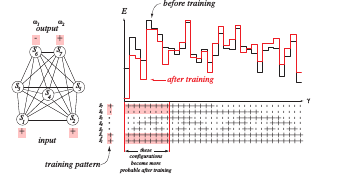

Fig.8: The fully connected seven-unit network at the left is being trained via the Boltzmann learning algorithm with the input pattern s1 = +1, s2 = +1, and the output values s6 = −1 and s7 = +1, representing categories ω1 and ω2 , respectively. All 25 = 32 conﬁgurations with s1 = +1, s2 = +1 are shown at the right, along with their energy (Eq. 1). The black curve shows the energy before training; the red curve shows the energy after training. Note particularly that after training all conﬁgurations that represent the full training pattern have been lowered in energy, i.e., have become more probable. Consequently, patterns that do not represent the training pattern become less probable after training. Thus, after training, if the input pattern s1 = +1, s2 = +1 is presented and the remaining network annealed, there is an increased chance of yielding s6 = −1, s7 = +1, as desired.


## Stochastic Boltzmann Learning

### Visible States Learning

Before diving into the central concern of learning categories from training patterns, consider an alternative learning problem. Here, we aim to match the desired probabilities for all visible units, denoted as $ Q(\alpha) $ (derived from a training set), with the actual probabilities $ P(\alpha) $, achieved through random simulations. These probabilities describe network states annealed without clamping input or output variables.

The probability of a visible configuration is given by:

$$
P(\alpha) = \sum_{\beta} P(\alpha, \beta) = \frac{\sum_{\beta} e^{-E_{\alpha\beta} / T}}{Z}
$$

where $ E_{\alpha\beta} $ is the system energy for a configuration defined by visible $ \alpha $ and hidden $ \beta $ units, and $ Z $ is the partition function.

A natural measure of the difference between the actual and desired probability distributions is the Kullback-Leibler (KL) divergence:

$$
D_{KL}(Q(\alpha), P(\alpha)) = \sum_{\alpha} Q(\alpha) \log \frac{Q(\alpha)}{P(\alpha)}.
$$

Gradient descent in this relative entropy is used for learning:

$$
\Delta w_{ij} = -\eta \frac{\partial D_{KL}}{\partial w_{ij}} = \eta \sum_{\alpha} \frac{Q(\alpha)}{P(\alpha)} \frac{\partial P(\alpha)}{\partial w_{ij}},
$$

where $ \eta $ is the learning rate. Substituting and simplifying:

$$
\Delta w_{ij} = \frac{\eta}{T} \left[ \mathbb{E}_Q[s_i s_j]^{\text{clamped}} - \mathbb{E}[s_i s_j]^{\text{free}} \right],
$$

where $ \mathbb{E}_Q[s_i s_j]^{\text{clamped}} $ is the correlation when visible units are clamped, and $ \mathbb{E}[s_i s_j]^{\text{free}} $ is the correlation when units are free to vary. Learning adjusts weights until these two terms are equal.

### Learning Input-Output Associations

To learn mappings from input to output, the network adjusts weights to match $ P(\alpha_o | \alpha_i) $ to $ Q(\alpha_o | \alpha_i) $, minimizing the KL divergence weighted by input probabilities:

$$
\bar{D}_{KL} = \sum_{\alpha_i} P(\alpha_i) \sum_{\alpha_o} Q(\alpha_o | \alpha_i) \log \frac{Q(\alpha_o | \alpha_i)}{P(\alpha_o | \alpha_i)}.
$$

The weight update rule is:

$$
\Delta w_{ij} = \frac{\eta}{T} \left[ \mathbb{E}_Q[s_i s_j]^{\alpha_i \alpha_o \text{ clamped}} - \mathbb{E}[s_i s_j]^{\alpha_i \text{ clamped}} \right].
$$

### Example of Learning a Single Pattern

Fig.8 illustrates a seven-unit network trained on:
- Input pattern: $ s_1 = +1, s_2 = +1 $
- Output pattern: $ s_6 = -1, s_7 = +1 $.

Initially, the network energy corresponds to random weights. Training lowers the energy for states with the desired output, increasing the likelihood of achieving the correct output during annealing.

For example, considering units $ s_1 $ and $ s_7 $:
- During learning, both are clamped at $ +1 $, so $ \mathbb{E}_Q[s_1 s_7] = +1 $.
- During unlearning, $ s_7 $ is free to vary, leading to a reduced correlation.

Weight updates strengthen associations between inputs and outputs while minimally adjusting hidden unit weights.

### Training Multiple Patterns

During training, each pattern in the dataset is presented sequentially, updating weights as described. Learning continues until the actual output matches the desired output for all patterns.

### References
- Fig.8: Training dynamics with a seven-unit network.
- Fig.9: Detailed learning of a single pattern.


In [9]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def energy(states, weights):
    """Compute the energy of a configuration."""
    return -0.5 * np.sum(weights * np.outer(states, states))

def boltzmann_learning(input_patterns, output_patterns, n_hidden, learning_rate, n_epochs):
    """
    Perform stochastic Boltzmann learning for input-output associations.

    Args:
        input_patterns (list of lists): Binary input patterns.
        output_patterns (list of lists): Binary output patterns.
        n_hidden (int): Number of hidden units.
        learning_rate (float): Learning rate (\u03b7).
        n_epochs (int): Number of training epochs.

    Returns:
        weights (numpy.ndarray): Learned weight matrix.
    """
    n_input = len(input_patterns[0])
    n_output = len(output_patterns[0])
    n_visible = n_input + n_output
    n_total = n_visible + n_hidden

    # Initialize weights randomly
    weights = np.random.normal(0, 0.1, (n_total, n_total))
    np.fill_diagonal(weights, 0)  # No self-connections

    for epoch in range(n_epochs):
        for idx, (input_pattern, output_pattern) in enumerate(zip(input_patterns, output_patterns)):
            # Create visible states (input + output)
            visible_states = np.array(input_pattern + output_pattern)

            # Positive phase (clamped states)
            clamped_states = np.zeros(n_total)
            clamped_states[:n_visible] = visible_states

            positive_correlation = np.outer(clamped_states, clamped_states)

            # Negative phase (free states)
            free_states = clamped_states.copy()
            for _ in range(100):  # Annealing steps
                for i in range(n_total):
                    energy_diff = np.dot(weights[i, :], free_states)
                    free_states[i] = 1 if np.random.rand() < sigmoid(energy_diff) else 0

            negative_correlation = np.outer(free_states, free_states)

            # Update weights
            weights += learning_rate * (positive_correlation - negative_correlation) / len(input_patterns)

        # Print epoch progress
        print(f"Epoch {epoch + 1}/{n_epochs} complete.")

    return weights

# Example usage
input_patterns = [[1, 0], [0, 1]]  # Two input patterns (binary)
output_patterns = [[0, 1], [1, 0]]  # Corresponding output patterns
n_hidden = 2
learning_rate = 0.01
n_epochs = 100

weights = boltzmann_learning(input_patterns, output_patterns, n_hidden, learning_rate, n_epochs)
print("Learned weights:")
print(weights)


Epoch 1/100 complete.
Epoch 2/100 complete.
Epoch 3/100 complete.
Epoch 4/100 complete.
Epoch 5/100 complete.
Epoch 6/100 complete.
Epoch 7/100 complete.
Epoch 8/100 complete.
Epoch 9/100 complete.
Epoch 10/100 complete.
Epoch 11/100 complete.
Epoch 12/100 complete.
Epoch 13/100 complete.
Epoch 14/100 complete.
Epoch 15/100 complete.
Epoch 16/100 complete.
Epoch 17/100 complete.
Epoch 18/100 complete.
Epoch 19/100 complete.
Epoch 20/100 complete.
Epoch 21/100 complete.
Epoch 22/100 complete.
Epoch 23/100 complete.
Epoch 24/100 complete.
Epoch 25/100 complete.
Epoch 26/100 complete.
Epoch 27/100 complete.
Epoch 28/100 complete.
Epoch 29/100 complete.
Epoch 30/100 complete.
Epoch 31/100 complete.
Epoch 32/100 complete.
Epoch 33/100 complete.
Epoch 34/100 complete.
Epoch 35/100 complete.
Epoch 36/100 complete.
Epoch 37/100 complete.
Epoch 38/100 complete.
Epoch 39/100 complete.
Epoch 40/100 complete.
Epoch 41/100 complete.
Epoch 42/100 complete.
Epoch 43/100 complete.
Epoch 44/100 complet

In [ ]:
### Missing Features, Category Constraints, and Pattern Completion in Boltzmann Machines

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Sigmoid function for probabilities
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Boltzmann Machine class
class BoltzmannMachine:
    def __init__(self, n_visible, n_hidden):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_units = n_visible + n_hidden

        # Initialize weights and biases
        self.weights = np.random.normal(0, 0.01, (self.n_units, self.n_units))
        np.fill_diagonal(self.weights, 0)  # No self-connections
        self.biases = np.zeros(self.n_units)

    def energy(self, state):
        """Compute energy of a given state."""
        return -0.5 * np.dot(state, np.dot(self.weights, state)) - np.dot(self.biases, state)

    def sample_units(self, probs):
        """Sample binary states based on probabilities."""
        return (np.random.rand(len(probs)) < probs).astype(np.float32)

    def anneal(self, visible_pattern, clamped_units):
        """Perform Gibbs sampling with clamped units."""
        state = np.copy(visible_pattern)

        for _ in range(100):  # Annealing steps
            for i in range(self.n_units):
                if i not in clamped_units:
                    activation = np.dot(self.weights[i], state) + self.biases[i]
                    prob = sigmoid(activation)
                    state[i] = self.sample_units(prob)

        return state

    def train(self, training_data, n_epochs=1000, learning_rate=0.1):
        """Train Boltzmann Machine using missing features and category constraints."""
        for epoch in range(n_epochs):
            positive_phase = np.zeros_like(self.weights)
            negative_phase = np.zeros_like(self.weights)

            for pattern in training_data:
                # Handle missing features
                visible_pattern = np.copy(pattern)
                missing_features = np.where(np.isnan(visible_pattern))[0]

                # Replace missing features with random values
                visible_pattern[missing_features] = np.random.choice([0, 1], len(missing_features))

                # Positive phase
                clamped_units = np.arange(self.n_visible)
                positive_state = self.anneal(visible_pattern, clamped_units)
                positive_phase += np.outer(positive_state, positive_state)

                # Negative phase (free-running)
                free_state = self.anneal(visible_pattern, [])
                negative_phase += np.outer(free_state, free_state)

            # Update weights and biases
            self.weights += learning_rate * (positive_phase - negative_phase) / len(training_data)
            self.biases += learning_rate * (np.mean(positive_phase, axis=0) - np.mean(negative_phase, axis=0))

    def complete_pattern(self, partial_pattern):
        """Perform pattern completion by annealing."""
        clamped_units = np.where(~np.isnan(partial_pattern))[0]
        state = np.nan_to_num(partial_pattern)  # Replace NaNs with zeros
        completed_state = self.anneal(state, clamped_units)
        return completed_state

# Example usage
n_visible = 6
n_hidden = 2
bm = BoltzmannMachine(n_visible, n_hidden)

# Generate some example training data
training_data = [
    np.array([1, 1, 0, 0, 1, 0]),
    np.array([0, 1, 1, 0, 0, 1]),
    np.array([1, 0, 0, 1, 1, 0]),
    np.array([1, 1, 1, 1, 0, 0])
]

# Train the Boltzmann Machine
bm.train(training_data)

# Perform pattern completion
partial_pattern = np.array([1, np.nan, np.nan, 1, np.nan, 0])
completed_pattern = bm.complete_pattern(partial_pattern)
print("Completed Pattern:", completed_pattern)

# Visualize original and completed pattern
plt.bar(range(len(partial_pattern)), np.nan_to_num(partial_pattern), label='Partial Pattern')
plt.bar(range(len(completed_pattern)), completed_pattern, alpha=0.5, label='Completed Pattern')
plt.legend()
plt.show()
